# CFO Forecasting - Financial Forecast Sandesh Brand 3 - Refinement

## Challenge Objective

The objective of this challenge is to generate the highest accuracy predictions possible for the 3 financial variables outlined below, for each of the two products.The accuracy of the forecast must at least improve on the Threshold target quoted for each variable / product.

 
The model should be tailored to a 12-mth forecast horizon but must be extendable beyond this time period.  

 
The accuracy of a prediction will be evaluated using MAPE (Mean Absolute Percentage Error) and maximum APE (Absolute Percentage Error) on the privatised data set over a period of 7 - 9 months.

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMA
import warnings
warnings.filterwarnings("ignore")

**Import and view data**

In [2]:
data = pd.read_csv('/Users/lukabeverin/Downloads/Sandesh3.csv', encoding='unicode_escape')
data.tail()

,Generic Group,Generic Brand,Generic Product Category,Generic Product,Generic Group variable,Generic Variable,Generic Sub-Variable,Generic LookupKey,Units,14/15_Q1_Apr,...,18/19_Q4_Feb,18/19_Q4_Mar,19/20_Q1_Apr,19/20_Q1_May,19/20_Q1_Jun,19/20_Q2_Jul,19/20_Q2_Aug,19/20_Q2_Sep,19/20_Q3_Oct,Unnamed: 76
92,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Falcon,Volume,Net Migrations - Falcon(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,-2.26,...,1.19,1.05,x,x,x,x,x,x,x,NaN
93,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Tortoise,Volume,Gross Adds - Tortoise(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,0.74,...,-0.22,-0.70,x,x,x,x,x,x,x,NaN
94,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Falcon,Volume,Gross Adds - Falcon(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,-1.65,...,1.25,0.95,x,x,x,x,x,x,x,NaN
95,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Tortoise,Volume,Leavers - Tortoise(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,-0.82,...,0.97,0.60,x,x,x,x,x,x,x,NaN
96,Segment 1 - Sandesh Brand 3,Sandesh Brand 3,Broadband,Falcon,Volume,Churn - Falcon(norm),Intentionally Blank,Segment 1 - Sandesh Brand 3Sandesh Brand 3Broa...,(000)s,-1.10,...,1.92,1.77,x,x,x,x,x,x,x,NaN


## Data cleaning and preparation

In [4]:
# Only interested in the following key targets

targets = ['Gross Adds - Falcon(norm)', 'Gross Adds - Tortoise(norm)','Net Migrations - Falcon(norm)', 'Net Migrations - Tortoise(norm)', 'Churn - Falcon(norm)','Leavers - Tortoise(norm)'] 
  
# Selecting and keeping rows based on condition of targets 
rslt_df = data.loc[data['Generic Variable'].isin(targets)]
rslt_df = rslt_df.reset_index(drop=True)

# Drop the cols that we do not need by index
rslt_df = rslt_df.drop(rslt_df.columns[[0,1,2,3,4,6,7,8]], axis=1)


# Change all nan values to zero.
rslt_df=rslt_df.fillna(0)

# Set the col 'Generic variable' as index so that we are able to transpose
rslt_df=rslt_df.set_index('Generic Variable')

# Transpose the data set so that we can have the dates as the rows and variables as cols.
df = rslt_df.transpose()

# Rename cols to remove index col name
df.columns = targets

# Remove strings of x
df = df.apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()
# Remove last row as it is filled with zeros
df = df[:-1]

# Delete index
df = df.reset_index(drop=True)
# Create dates for the new index
df['Date'] = pd.date_range(start='4/2014', periods=len(df), freq='MS')
df=df.set_index('Date')
# Convert data type to float so that we can output plots
df=df.astype(float)

df.head()

,Gross Adds - Falcon(norm),Gross Adds - Tortoise(norm),Net Migrations - Falcon(norm),Net Migrations - Tortoise(norm),Churn - Falcon(norm),Leavers - Tortoise(norm)
Date,,,,,,
2014-04-01,2.26,-2.26,0.74,-1.65,-0.82,-1.10
2014-05-01,2.01,-2.01,1.73,-1.72,0.47,-1.08
2014-06-01,2.52,-2.52,-0.35,-1.81,-2.22,-1.13
2014-07-01,2.18,-2.18,0.17,-1.54,-0.90,-1.09
2014-08-01,1.17,-1.17,1.09,-1.04,0.68,-1.00


### Simple statistics of key targets

In [5]:
df.describe()

,Gross Adds - Falcon(norm),Gross Adds - Tortoise(norm),Net Migrations - Falcon(norm),Net Migrations - Tortoise(norm),Churn - Falcon(norm),Leavers - Tortoise(norm)
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.010833,-0.010833,0.138667,-0.144500,0.063667,-0.186833
std,1.048486,1.048486,0.960543,0.953346,1.029532,0.871608
min,-2.330000,-2.520000,-1.560000,-1.810000,-2.220000,-1.130000
25%,-0.715000,-0.740000,-0.445000,-0.892500,-0.622500,-0.877500
50%,-0.110000,0.110000,0.065000,-0.405000,0.050000,-0.305000
75%,0.740000,0.715000,0.725000,0.705000,0.620000,0.110000
max,2.520000,2.330000,3.150000,1.490000,2.510000,2.440000


### Correlation heatmap

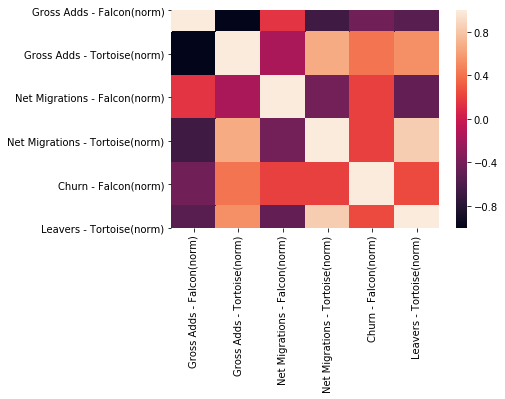

In [34]:
import seaborn as sns

corr = df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Plot key targets

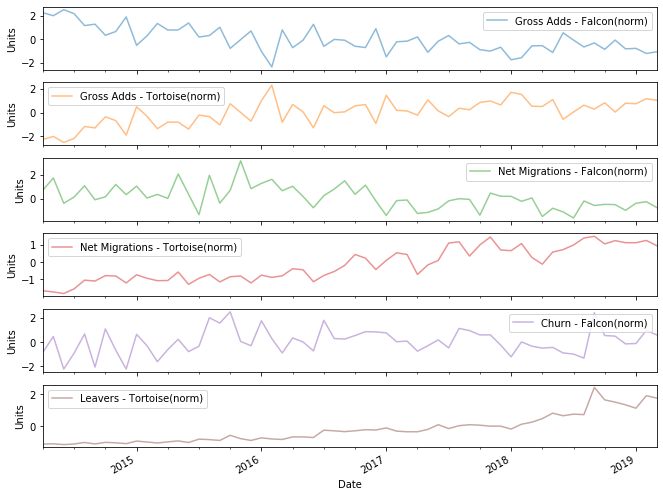

In [6]:
plots = ['Gross Adds - Falcon(norm)', 'Gross Adds - Tortoise(norm)','Net Migrations - Falcon(norm)', 'Net Migrations - Tortoise(norm)', 'Churn - Falcon(norm)','Leavers - Tortoise(norm)']
axes = df[plots].plot(alpha=0.5, figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Units')

# Methodology 

### Seasonal ARIMA Model

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term 's' is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.). Looking at the plots of the key targets we choose a periodicity of 12.

We will use a **“grid search”** to iteratively explore different combinations of parameters. For each combination of parameters, we fit a ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest, which is the AIC.


#### Set the parameters 

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets with s = 12
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

## Gross Adds - Falcon(norm)

In [8]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aic= []
parameters = []
seasonal_param = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df[['Gross Adds - Falcon(norm)']],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit()
            # save results in lists
            aic.append(results.aic)
            parameters.append(param)
            seasonal_param.append(param_seasonal)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
# find lowest aic            
index_min = min(range(len(aic)), key=aic.__getitem__)             

print('The optimal model is: ARIMA{}x{}12 - AIC:{}'.format(parameters[index_min], seasonal_param[index_min], aic[index_min]))
                

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:176.952383937123
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:167.40752479000284
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:163.343167728001
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:134.47162068009914
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:135.87489574219495
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:134.7979615867034
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:130.7397857380219
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:118.59134348450658
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:117.15894621189123
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:163.32922448676024
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:165.32076017894718
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:164.47281220756258
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:135.58636071170048
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:136.03088290985676
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:136.69264764219835
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:114.96789716814816
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:116.88418717928666
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:118.8841940918120

ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:105.53951638500308
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:107.36352072451949
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:110.63530749997348
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:108.35705920665146
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:109.27304223806003
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:128.835903553611
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:130.71790638024765
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:132.27341746475182
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:105.4894796194154
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:107.09068456923872
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:108.81910546037068
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:106.18490371728561
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:107.9275572882563
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:109.83431862883315
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:235.06777270344193
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:232.84612119171152
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:231.37331551225725
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:202.98556599133

ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:122.07518257379749
ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:123.94535611762423
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:151.19340223006878
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:143.61190351609903
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:138.97948707831893
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:119.99099679398843
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:108.88071314735123
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:109.62591657684797
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:127.27347972181354
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:114.85391809608026
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:112.79400061166655
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:137.85811139081366
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:135.79697035571382
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:136.2115194552823
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:107.92898262651762
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:109.59528678595464
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:111.5627406583085
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:112.743201663

ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:143.08444974917214
ARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:144.55386257649187
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:117.66333393379084
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:119.24807235214928
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:121.24309206905373
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:121.44490456739287
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:119.09403894509438
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:120.4124233341874
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:142.66972700105765
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:144.66392478450197
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:146.3264025628176
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:119.26362852964783
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:121.23701401150744
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:123.23888680498823
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:118.20796131283915
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:120.095624325724
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:122.25134962398279
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:151.01744020079

ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:109.44621679376883
ARIMA(2, 1, 0)x(2, 2, 0, 12)12 - AIC:108.09729086845049
ARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:109.56867738564652
ARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:111.34266158326145
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:141.15304795814745
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:138.82502314571093
ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:134.24476330307942
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:115.86930625034879
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:106.07205608240564
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:106.49134463272607
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:131.76983515989232
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:113.03057526189458
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:108.71713118082707
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:134.32411196484617
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:130.07897251633804
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:130.79779515468795
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:104.7951223626337
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:106.53933761

In [9]:
mod = sm.tsa.statespace.SARIMAX(df[['Gross Adds - Falcon(norm)']],
                                order=parameters[index_min],
                                seasonal_order=seasonal_param[index_min],
                                enforce_stationarity=True,
                                enforce_invertibility=True)

results = mod.fit()

print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:           Gross Adds - Falcon(norm)   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -47.770
Date:                             Sat, 28 Mar 2020   AIC                            103.540
Time:                                     21:10:14   BIC                            110.940
Sample:                                 04-01-2014   HQIC                           106.324
                                      - 03-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.176     -2.351      0.019      -0.758      -0.069
ma.L1         -0.6282      

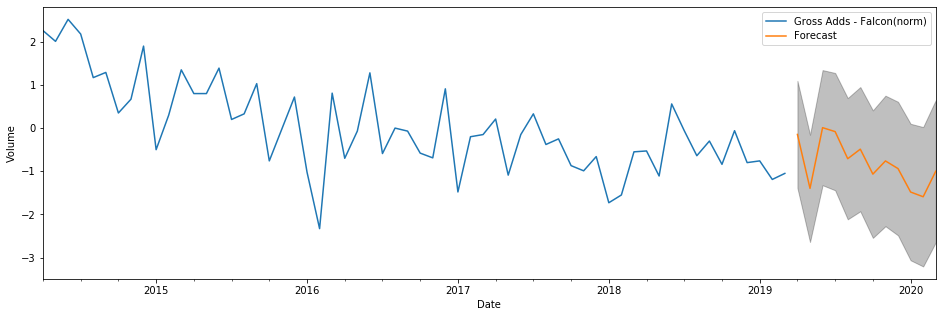

In [10]:
# Get forecast 12 steps ahead in future (12 months)
pred_uc = results.get_forecast(steps=12, simple_differencing = False)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = df[['Gross Adds - Falcon(norm)']].plot(label='observed', figsize=(16, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')

plt.legend()
plt.show()

In [11]:
#output forecasted values
GA_Falcon = pred_uc.predicted_mean
GA_Falcon = pd.DataFrame(GA_Falcon)
GA_Falcon.columns = ['Gross Adds - Falcon(norm)']
GA_Falcon.index = GA_Falcon.index.rename('Date')
GA_Falcon.head(12)

,Gross Adds - Falcon(norm)
Date,
2019-04-01,-0.147359
2019-05-01,-1.396781
2019-06-01,0.010210
2019-07-01,-0.081793
2019-08-01,-0.709472
2019-09-01,-0.488308
2019-10-01,-1.066805
2019-11-01,-0.761026
2019-12-01,-0.938361


## Gross Adds - Tortoise(norm)

In [12]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aic= []
parameters = []
seasonal_param = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df[['Gross Adds - Tortoise(norm)']],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit()
            # save results in lists
            aic.append(results.aic)
            parameters.append(param)
            seasonal_param.append(param_seasonal)

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
# find lowest aic            
index_min = min(range(len(aic)), key=aic.__getitem__)             

print('The optimal model is: ARIMA{}x{}12 - AIC:{}'.format(parameters[index_min], seasonal_param[index_min], aic[index_min]))

The optimal model is: ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:103.53954326673492


In [13]:
mod = sm.tsa.statespace.SARIMAX(df[['Gross Adds - Tortoise(norm)']],
                                order=parameters[index_min],
                                seasonal_order=seasonal_param[index_min],
                                enforce_stationarity=True,
                                enforce_invertibility=True)

results = mod.fit()

print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:         Gross Adds - Tortoise(norm)   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -47.770
Date:                             Sat, 28 Mar 2020   AIC                            103.540
Time:                                     21:22:23   BIC                            110.940
Sample:                                 04-01-2014   HQIC                           106.324
                                      - 03-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.176     -2.351      0.019      -0.758      -0.069
ma.L1         -0.6282      

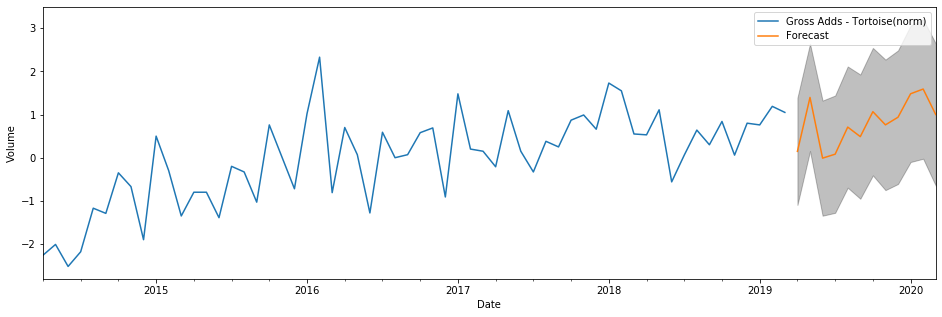

In [14]:
# Get forecast 12 steps ahead in future (12 months)
pred_uc = results.get_forecast(steps=12, simple_differencing = False)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()


ax = df[['Gross Adds - Tortoise(norm)']].plot(label='observed', figsize=(16, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')

plt.legend()
plt.show()


In [15]:
#output forecasted values
GA_Tortoise = pred_uc.predicted_mean
GA_Tortoise= pd.DataFrame(GA_Tortoise)
GA_Tortoise.columns = ['Gross Adds - Tortoise(norm)']
GA_Tortoise.index = GA_Tortoise.index.rename('Date')
GA_Tortoise.head(12)

,Gross Adds - Tortoise(norm)
Date,
2019-04-01,0.147359
2019-05-01,1.396781
2019-06-01,-0.010210
2019-07-01,0.081793
2019-08-01,0.709472
2019-09-01,0.488308
2019-10-01,1.066805
2019-11-01,0.761026
2019-12-01,0.938361


## Net Migrations - Falcon(norm)


In [16]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aic= []
parameters = []
seasonal_param = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df[['Net Migrations - Falcon(norm)']],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit()
            # save results in lists
            aic.append(results.aic)
            parameters.append(param)
            seasonal_param.append(param_seasonal)

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
# find lowest aic            
index_min = min(range(len(aic)), key=aic.__getitem__)             

print('The optimal model is: ARIMA{}x{}12 - AIC:{}'.format(parameters[index_min], seasonal_param[index_min], aic[index_min]))
    

The optimal model is: ARIMA(0, 1, 1)x(2, 2, 0, 12)12 - AIC:129.96955203234614


In [17]:
mod = sm.tsa.statespace.SARIMAX(df[['Net Migrations - Falcon(norm)']],
                                order=parameters[index_min],
                                seasonal_order=seasonal_param[index_min],
                                enforce_stationarity=True,
                                enforce_invertibility=True)

results = mod.fit()

print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:       Net Migrations - Falcon(norm)   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(2, 2, [], 12)   Log Likelihood                 -60.985
Date:                             Sat, 28 Mar 2020   AIC                            129.970
Time:                                     21:35:52   BIC                            136.191
Sample:                                 04-01-2014   HQIC                           132.117
                                      - 03-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7909      0.197     -4.020      0.000      -1.177      -0.405
ar.S.L12      -1.1706      

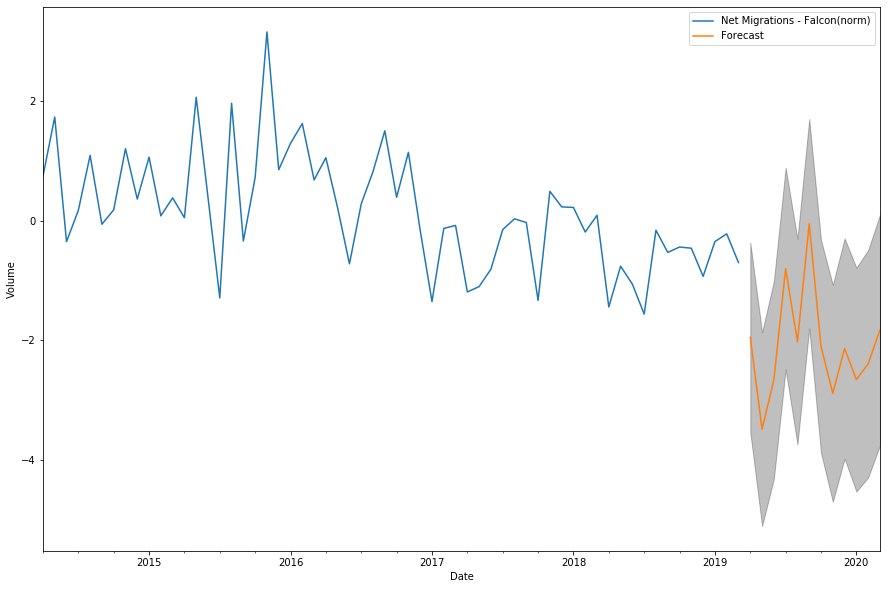

In [18]:
# Get forecast 12 steps ahead in future (12 months)
pred_uc = results.get_forecast(steps=12, simple_differencing = False)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = df[['Net Migrations - Falcon(norm)']].plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')


plt.legend()
plt.show()

In [19]:
#output forecasted values
NM_Falcon = pred_uc.predicted_mean
NM_Falcon = pd.DataFrame(NM_Falcon)
NM_Falcon.columns = ['Net Migrations - Falcon(norm)']
NM_Falcon.index = NM_Falcon.index.rename('Date')
NM_Falcon.head(12)

,Net Migrations - Falcon(norm)
Date,
2019-04-01,-1.946340
2019-05-01,-3.480516
2019-06-01,-2.658396
2019-07-01,-0.800174
2019-08-01,-2.020454
2019-09-01,-0.052459
2019-10-01,-2.099299
2019-11-01,-2.882541
2019-12-01,-2.133205


## Net Migrations - Tortoise(norm)

In [20]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aic= []
parameters = []
seasonal_param = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df[['Net Migrations - Tortoise(norm)']],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit()
            # save results in lists
            aic.append(results.aic)
            parameters.append(param)
            seasonal_param.append(param_seasonal)

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
# find lowest aic            
index_min = min(range(len(aic)), key=aic.__getitem__)             

print('The optimal model is: ARIMA{}x{}12 - AIC:{}'.format(parameters[index_min], seasonal_param[index_min], aic[index_min]))
    

The optimal model is: ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:50.00675552631294


In [21]:
mod = sm.tsa.statespace.SARIMAX(df[['Net Migrations - Tortoise(norm)']],
                                order=parameters[index_min],
                                seasonal_order=seasonal_param[index_min],
                                enforce_stationarity=True,
                                enforce_invertibility=True)

results = mod.fit()

print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:      Net Migrations - Tortoise(norm)   No. Observations:                   60
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -21.003
Date:                              Sat, 28 Mar 2020   AIC                             50.007
Time:                                      21:53:50   BIC                             57.407
Sample:                                  04-01-2014   HQIC                            52.792
                                       - 03-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1964      0.168     -1.171      0.241      -0.525       0.132
ma.L2         -0.59

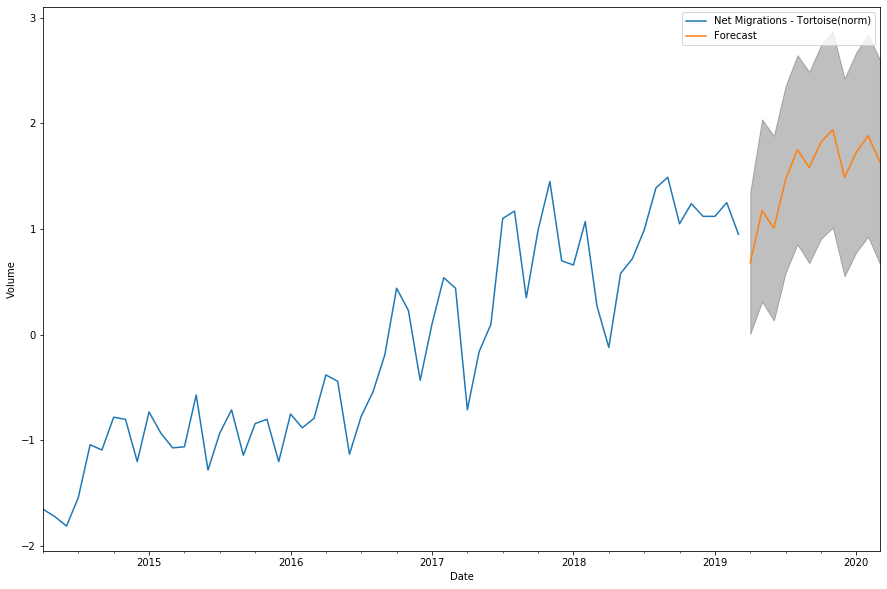

In [22]:
# Get forecast 12 steps ahead in future (12 months)
pred_uc = results.get_forecast(steps=12, simple_differencing = False)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = df[['Net Migrations - Tortoise(norm)']].plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')


plt.legend()
plt.show()

In [23]:
#output forecasted values
NM_Tortoise = pred_uc.predicted_mean
NM_Tortoise = pd.DataFrame(NM_Tortoise)
NM_Tortoise.columns = ['Net Migrations - Tortoise(norm)']
NM_Tortoise.index = NM_Tortoise.index.rename('Date')
NM_Tortoise.head(12)

,Net Migrations - Tortoise(norm)
Date,
2019-04-01,0.681471
2019-05-01,1.175617
2019-06-01,1.008238
2019-07-01,1.469574
2019-08-01,1.750470
2019-09-01,1.582386
2019-10-01,1.822833
2019-11-01,1.939310
2019-12-01,1.488219


## Churn - Falcon(norm)


In [24]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aic= []
parameters = []
seasonal_param = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df[['Churn - Falcon(norm)']],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit()
            # save results in lists
            aic.append(results.aic)
            parameters.append(param)
            seasonal_param.append(param_seasonal)

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
# find lowest aic            
index_min = min(range(len(aic)), key=aic.__getitem__)             

print('The optimal model is: ARIMA{}x{}12 - AIC:{}'.format(parameters[index_min], seasonal_param[index_min], aic[index_min]))
    

The optimal model is: ARIMA(0, 1, 1)x(2, 2, 0, 12)12 - AIC:135.46926010490034


In [25]:
mod = sm.tsa.statespace.SARIMAX(df[['Churn - Falcon(norm)']],
                                order=parameters[index_min],
                                seasonal_order=seasonal_param[index_min],
                                enforce_stationarity=True,
                                enforce_invertibility=True)

results = mod.fit()

print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                Churn - Falcon(norm)   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(2, 2, [], 12)   Log Likelihood                 -63.735
Date:                             Sat, 28 Mar 2020   AIC                            135.469
Time:                                     22:18:46   BIC                            141.691
Sample:                                 04-01-2014   HQIC                           137.617
                                      - 03-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7677      0.146     -5.269      0.000      -1.053      -0.482
ar.S.L12      -1.0898      

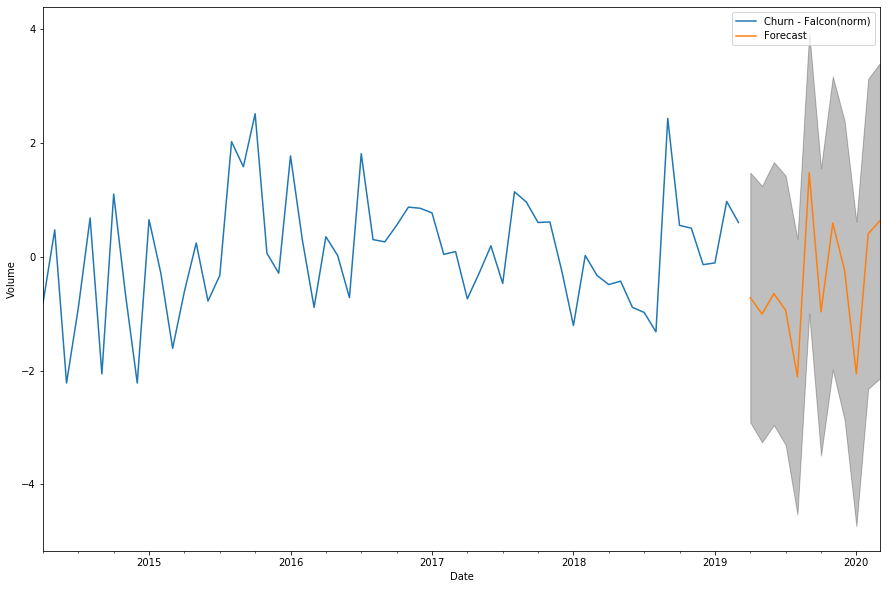

In [26]:
# Get forecast 12 steps ahead in future (12 months)
pred_uc = results.get_forecast(steps=12, simple_differencing = False)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = df[['Churn - Falcon(norm)']].plot(label='observed', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')

plt.legend()
plt.show()

In [27]:
#output forecasted values
C_Falcon = pred_uc.predicted_mean
C_Falcon = pd.DataFrame(C_Falcon)
C_Falcon.columns = ['Churn - Falcon(norm)']
C_Falcon.index = C_Falcon.index.rename('Date')
C_Falcon.head(12)

,Churn - Falcon(norm)
Date,
2019-04-01,-0.717552
2019-05-01,-1.009041
2019-06-01,-0.648149
2019-07-01,-0.940965
2019-08-01,-2.109348
2019-09-01,1.475928
2019-10-01,-0.969655
2019-11-01,0.591019
2019-12-01,-0.240527


## Leavers - Tortoise(norm)  
**ARIMA Model (No seasonal component)**

In [28]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aic= []
parameters = []


for param in pdq:
    #for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df[['Leavers - Tortoise(norm)']],
                                            order=param,
                                            #seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit()
            # save results in lists
            aic.append(results.aic)
            parameters.append(param)
            #seasonal_param.append(param_seasonal)

            #print('ARIMA{} - AIC:{}'.format(param, results.aic))
        except:
            continue
            
# find lowest aic            
index_min = min(range(len(aic)), key=aic.__getitem__)             

print('The optimal model is: ARIMA{} - AIC:{}'.format(parameters[index_min], aic[index_min]))

The optimal model is: ARIMA(0, 1, 1) - AIC:22.696839913942874


In [29]:
model = ARIMA(df[['Leavers - Tortoise(norm)']], order=parameters[index_min])
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                 ARIMA Model Results                                  
Dep. Variable:     D.Leavers - Tortoise(norm)   No. Observations:                   59
Model:                         ARIMA(0, 1, 1)   Log Likelihood                  -6.466
Method:                               css-mle   S.D. of innovations              0.269
Date:                        Sat, 28 Mar 2020   AIC                             18.932
Time:                                22:19:42   BIC                             25.165
Sample:                            05-01-2014   HQIC                            21.365
                                 - 03-01-2019                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.0488      0.017      2.833      0.005       0.015       0.083
m

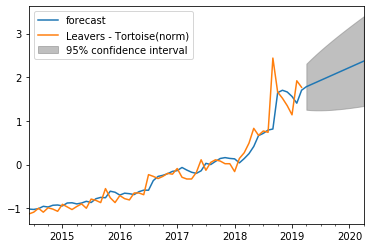

In [30]:
#we want to forecast the next 12 months
model_fit.plot_predict(start=2, end=len(df)+12)
plt.show()

In [31]:
pred = model_fit.predict(start='2019-04-01', end=len(df)+12,typ='levels')
L_Tortoise = pd.DataFrame(pred)
L_Tortoise.columns = ['Leavers - Tortoise(norm)']
L_Tortoise.index = L_Tortoise.index.rename('Date')
L_Tortoise.head(12)


,Leavers - Tortoise(norm)
Date,
2019-04-01,1.784246
2019-05-01,1.833067
2019-06-01,1.881889
2019-07-01,1.930710
2019-08-01,1.979531
2019-09-01,2.028353
2019-10-01,2.077174
2019-11-01,2.125995
2019-12-01,2.174817


### Making submission file

In [38]:
results = pd.concat([ NM_Tortoise, NM_Falcon, GA_Tortoise, GA_Falcon, L_Tortoise, C_Falcon],axis = 1)
results.columns = ['Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise(norm)', 'Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon(norm)','Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise(norm)','Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon(norm)','Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise(norm)','Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon(norm)']
results = results[:-1]
results.tail()

,Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseNet Migrations - Tortoise(norm),Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconNet Migrations - Falcon(norm),Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseGross Adds - Tortoise(norm),Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconGross Adds - Falcon(norm),Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandTortoiseLeavers - Tortoise(norm),Segment 1 - Sandesh Brand 3Sandesh Brand 3BroadbandFalconChurn - Falcon(norm)
Date,,,,,,
2019-11-01,1.939310,-2.882541,0.761026,-0.761026,2.125995,0.591019
2019-12-01,1.488219,-2.133205,0.938361,-0.938361,2.174817,-0.240527
2020-01-01,1.727784,-2.653015,1.481683,-1.481683,2.223638,-2.058812
2020-02-01,1.882596,-2.388386,1.591153,-1.591153,2.272459,0.400944
2020-03-01,1.634862,-1.825692,0.999445,-0.999445,2.321280,0.631476


In [39]:
results.to_csv('submission_Sandesh3.csv', index=True, header=True)

**Notebook completed by Luka**